# Pigpen PyTorch Example
by Joe Norton

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [24]:
import random
from PigpenDataset import PigpenDatasetClass


In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))  # Example normalization
])

train_dataset = PigpenDatasetClass('data/train', transform=transform)
test_dataset = PigpenDatasetClass('data/test', transform=transform)
valid_dataset = PigpenDatasetClass('data/validation', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=27, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=27, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=27, shuffle=False)

In [26]:
len(train_dataset), len(test_dataset), len(valid_dataset)

(54000, 10800, 10800)

In [27]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 28)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=28, bias=True)
  )
)


In [28]:

# Create the network, define a loss function, and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [29]:
epoch_val_loss = []
epoch_val_acc = []

In [30]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    epoch_val_loss.append(test_loss)
    epoch_val_acc.append((100*correct))

In [31]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(valid_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.299440  [   27/54000]
loss: 2.984580  [ 2727/54000]
loss: 2.079112  [ 5427/54000]
loss: 1.016214  [ 8127/54000]
loss: 0.841254  [10827/54000]
loss: 0.902645  [13527/54000]
loss: 0.590333  [16227/54000]
loss: 1.077843  [18927/54000]
loss: 0.666389  [21627/54000]
loss: 0.606644  [24327/54000]
loss: 0.551212  [27027/54000]
loss: 0.777076  [29727/54000]
loss: 0.649748  [32427/54000]
loss: 0.816776  [35127/54000]
loss: 0.909134  [37827/54000]
loss: 0.363323  [40527/54000]
loss: 0.327688  [43227/54000]
loss: 0.311418  [45927/54000]
loss: 0.281961  [48627/54000]
loss: 0.212202  [51327/54000]
Test Error: 
 Accuracy: 63.2%, Avg loss: 1.208270 

Epoch 2
-------------------------------
loss: 0.368789  [   27/54000]
loss: 0.367427  [ 2727/54000]
loss: 0.229923  [ 5427/54000]
loss: 0.409425  [ 8127/54000]
loss: 0.333492  [10827/54000]
loss: 0.312300  [13527/54000]
loss: 0.440367  [16227/54000]
loss: 0.321757  [18927/54000]
loss: 0.185651  [21627/54000

<function matplotlib.pyplot.show(close=None, block=None)>

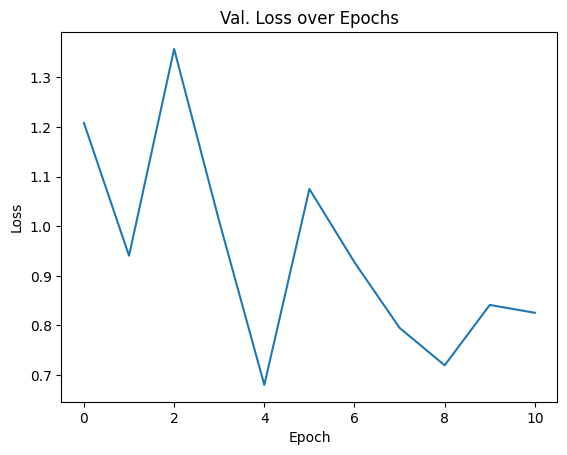

In [36]:
from matplotlib import pyplot as plt
plt.plot(epoch_val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val. Loss over Epochs')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

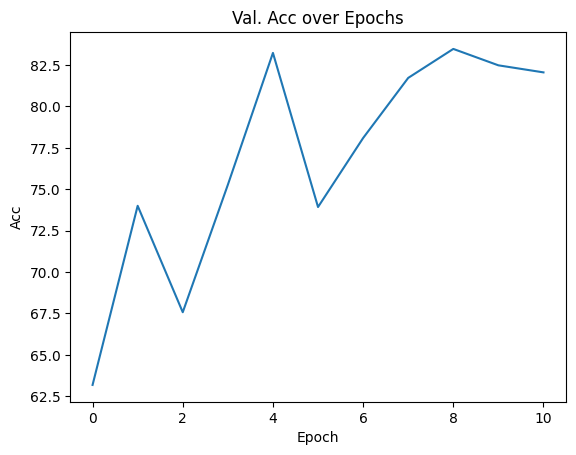

In [37]:
plt.plot(epoch_val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Val. Acc over Epochs')
plt.show

In [34]:
test(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 82.1%, Avg loss: 0.825557 

